In [1]:
!pip install medmnist tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import medmnist
from medmnist import INFO


In [3]:
data_flag = 'pneumoniamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

In [4]:
train_dataset = DataClass(split='train', download=download, as_rgb=False)
val_dataset   = DataClass(split='val', download=download, as_rgb=False)
test_dataset  = DataClass(split='test', download=download, as_rgb=False)

100%|██████████| 4.17M/4.17M [00:06<00:00, 643kB/s]


In [5]:
x_train, y_train = train_dataset.imgs, train_dataset.labels.ravel()
x_val, y_val     = val_dataset.imgs, val_dataset.labels.ravel()
x_test, y_test   = test_dataset.imgs, test_dataset.labels.ravel()

print("Train:", x_train.shape, y_train.shape)

Train: (4708, 28, 28) (4708,)


In [6]:
# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_val   = x_val.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0


In [7]:
# Reshape to (28,28,1) for CNN
x_train = np.expand_dims(x_train, -1)
x_val   = np.expand_dims(x_val, -1)
x_test  = np.expand_dims(x_test, -1)

print("Input shape for CNN:", x_train.shape)

Input shape for CNN: (4708, 28, 28, 1)


In [8]:
cnn = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

cnn.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy"])

cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,385 (939.00 KB)

 Trainable params: 240,385 (939.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = cnn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=[es]
)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.7448 - loss: 0.5558 - val_accuracy: 0.8740 - val_loss: 0.3683
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.8582 - loss: 0.3348 - val_accuracy: 0.8989 - val_loss: 0.2270
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9029 - loss: 0.2348 - val_accuracy: 0.9160 - val_loss: 0.1994
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9115 - loss: 0.2137 - val_accuracy: 0.9294 - val_loss: 0.1652
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9327 - loss: 0.1608 - val_accuracy: 0.9523 - val_loss: 0.1425
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9394 - loss: 0.1585 - val_accuracy: 0.9561 - val_loss: 0.1281
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9520 - loss: 0.1283 - val_accuracy: 0.9523 - val_loss: 0.1271
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9495 - loss: 0.1344 - val_accuracy: 0.9580

In [10]:
y_prob = cnn.predict(x_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("CNN AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
CNN AUC: 0.9433431952662722
[[139  95]
 [  4 386]]
              precision    recall  f1-score   support

           0     0.9720    0.5940    0.7374       234
           1     0.8025    0.9897    0.8863       390

    accuracy                         0.8413       624
   macro avg     0.8873    0.7919    0.8119       624
weighted avg     0.8661    0.8413    0.8305       624



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [12]:
# --- CNN Predictions ---
y_pred_cnn = cnn.predict(x_test)              # probabilities
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)    # convert to class labels


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


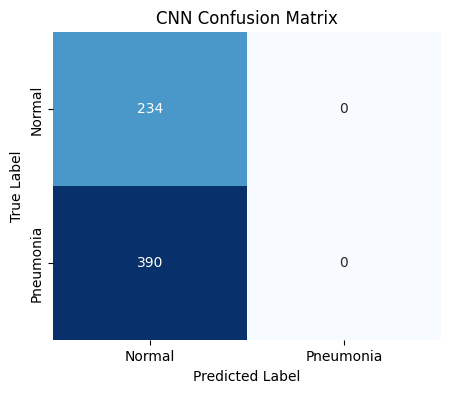

CNN Classification Report:
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(5,4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CNN Confusion Matrix")
plt.show()

# --- Classification Report ---
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=['Normal', 'Pneumonia']))